
# K-Nearest Neighbors (KNN) Classifier — National Cuisine Dataset

**Objective:** Build a KNN classifier for the provided `cleaned_cuisines.csv` dataset and **retrain/tweak parameters** (`n_neighbors`, `weights`, `metric`, `p`) to see how they affect model performance. The notebook includes explanations after each experiment to discuss why certain parameter choices help or degrade the model quality.


In [2]:

# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# For reproducibility
RANDOM_STATE = 42

# 2. Load dataset (ensure the CSV is in the same runtime environment)
df = pd.read_csv('../data/cleaned_cuisines.csv')
# Drop unnamed index column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print('Shape:', df.shape)
display(df.head())
display(df['cuisine'].value_counts())


Shape: (3995, 381)


,cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,...,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
0,indian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,indian,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,indian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,indian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,indian,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


cuisine
indian      799
thai        799
chinese     799
japanese    799
korean      799
Name: count, dtype: int64


## Data preprocessing notes

- The dataset contains a `cuisine` column (target) and many binary ingredient columns (features).  
- KNN is sensitive to scaling and distance metrics; however, since features are binary (0/1), scaling may or may not improve performance. We will compare raw binary features vs standardized features.  
- We'll encode the `cuisine` labels to integers for modeling.


In [3]:

# 3. Preprocessing
# Separate X and y
X = df.drop(columns=['cuisine'])
y = df['cuisine']

# Label encode the cuisine target
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_

print('Classes:', list(class_names))
print('Feature count:', X.shape[1])


Classes: ['chinese', 'indian', 'japanese', 'korean', 'thai']
Feature count: 380


In [4]:

# 4. Train-test split (stratified to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=RANDOM_STATE, stratify=y_enc
)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (3196, 380) Test shape: (799, 380)



## Baseline KNN model

We'll start with a baseline KNN using `n_neighbors=5`, `weights='uniform'`, metric='minkowski' (Euclidean, p=2) on **raw** binary data. We'll evaluate accuracy and the classification report.


Baseline accuracy: 0.7571964956195244

Classification report:
               precision    recall  f1-score   support

     chinese       0.61      0.74      0.67       160
      indian       0.87      0.83      0.85       159
    japanese       0.71      0.86      0.78       160
      korean       0.88      0.64      0.74       160
        thai       0.79      0.71      0.75       160

    accuracy                           0.76       799
   macro avg       0.77      0.76      0.76       799
weighted avg       0.77      0.76      0.76       799



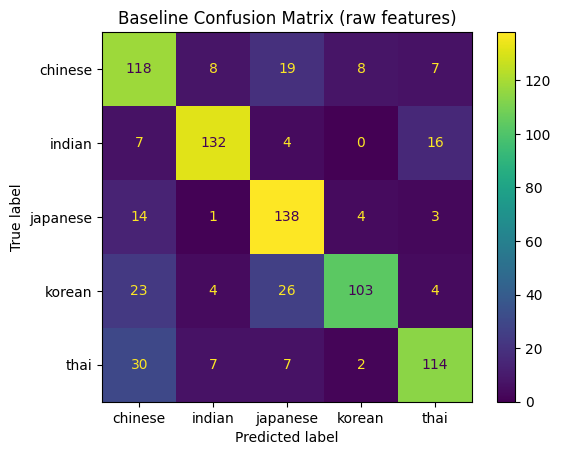

In [5]:

# Baseline KNN on raw binary features
knn_base = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski', p=2)
knn_base.fit(X_train, y_train)

y_pred_base = knn_base.predict(X_test)
print('Baseline accuracy:', accuracy_score(y_test, y_pred_base))
print('\nClassification report:\n', classification_report(y_test, y_pred_base, target_names=class_names))
cm = confusion_matrix(y_test, y_pred_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.title('Baseline Confusion Matrix (raw features)')
plt.show()



## Effect of Standardization (Scaling)

Although features are binary, we'll test whether standardizing features (mean=0, sd=1) changes KNN performance. For continuous data, scaling is required; for binary, it may or may not help. We will fit and evaluate a KNN on standardized features.


Scaled KNN accuracy: 0.7634543178973717

Classification report (scaled):
               precision    recall  f1-score   support

     chinese       0.69      0.64      0.66       160
      indian       0.85      0.84      0.85       159
    japanese       0.71      0.82      0.76       160
      korean       0.80      0.69      0.74       160
        thai       0.78      0.83      0.80       160

    accuracy                           0.76       799
   macro avg       0.76      0.76      0.76       799
weighted avg       0.76      0.76      0.76       799



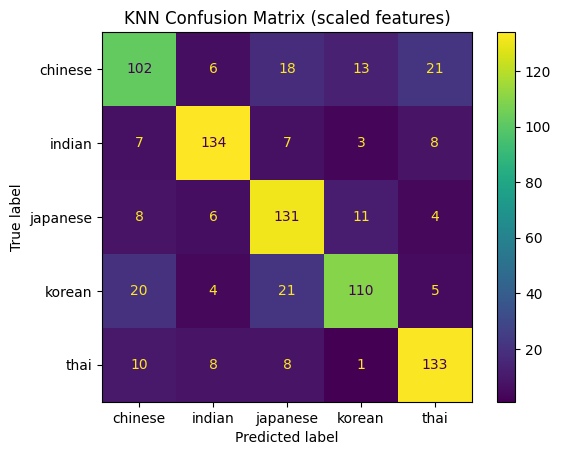

In [6]:

# Pipeline with scaling
pipe_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski', p=2))
])
pipe_scaled.fit(X_train, y_train)
y_pred_scaled = pipe_scaled.predict(X_test)

print('Scaled KNN accuracy:', accuracy_score(y_test, y_pred_scaled))
print('\nClassification report (scaled):\n', classification_report(y_test, y_pred_scaled, target_names=class_names))
cm2 = confusion_matrix(y_test, y_pred_scaled)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=class_names)
disp2.plot()
plt.title('KNN Confusion Matrix (scaled features)')
plt.show()



## Parameter sweeps: `n_neighbors`, `weights`, and `p` (distance)

We will sweep across a set of `n_neighbors` values, compare `weights='uniform'` vs `weights='distance'`, and compare `p=1` (Manhattan) vs `p=2` (Euclidean).

*Expected behavior:*  
- Small `n_neighbors` → lower bias, higher variance (may overfit).  
- Large `n_neighbors` → higher bias, lower variance (may underfit).  
- `weights='distance'` often helps when nearer neighbors should have more influence, especially with variable density.  
- `p=1` vs `p=2` can change performance depending on data geometry; for high-dimensional sparse binary data, Manhattan (p=1) or cosine distance may be preferable.


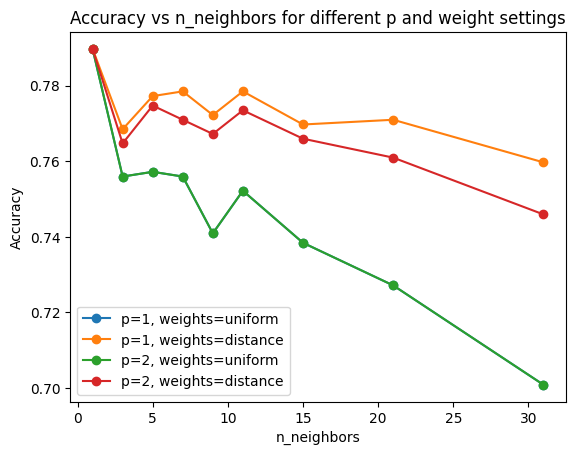

,p,weights,n_neighbors,accuracy
9,1,distance,1,0.789737
10,1,distance,3,0.768461
11,1,distance,5,0.777222
12,1,distance,7,0.778473
13,1,distance,9,0.772215
14,1,distance,11,0.778473
15,1,distance,15,0.769712
16,1,distance,21,0.770964
17,1,distance,31,0.759700
0,1,uniform,1,0.789737


In [7]:

# Sweep settings
neighbors = [1,3,5,7,9,11,15,21,31]
weights_opts = ['uniform', 'distance']
ps = [1,2]

results = []
for p in ps:
    for w in weights_opts:
        acc_list = []
        for k in neighbors:
            knn = KNeighborsClassifier(n_neighbors=k, weights=w, p=p, metric='minkowski')
            knn.fit(X_train, y_train)
            yp = knn.predict(X_test)
            acc = accuracy_score(y_test, yp)
            acc_list.append(acc)
            results.append({'p': p, 'weights': w, 'n_neighbors': k, 'accuracy': acc})
        # Plot accuracy vs neighbors for this p and weight
        plt.plot(neighbors, acc_list, marker='o', label=f'p={p}, weights={w}')
plt.xscale('linear')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs n_neighbors for different p and weight settings')
plt.legend()
plt.show()

res_df = pd.DataFrame(results)
display(res_df.sort_values(['p','weights','n_neighbors']).head(12))



## Try Cosine distance (suitable for high-dimensional binary/sparse data)

Cosine distance measures the angle between vectors and often works well for high-dimensional sparse binary features (like ingredient presence). We'll test KNN with `metric='cosine'` and `weights='distance'` (using `algorithm='brute'` if needed).


Cosine KNN accuracy: 0.8135168961201502

Classification report (cosine):
               precision    recall  f1-score   support

     chinese       0.77      0.78      0.78       160
      indian       0.92      0.89      0.91       159
    japanese       0.81      0.88      0.84       160
      korean       0.73      0.75      0.74       160
        thai       0.84      0.77      0.80       160

    accuracy                           0.81       799
   macro avg       0.82      0.81      0.81       799
weighted avg       0.82      0.81      0.81       799



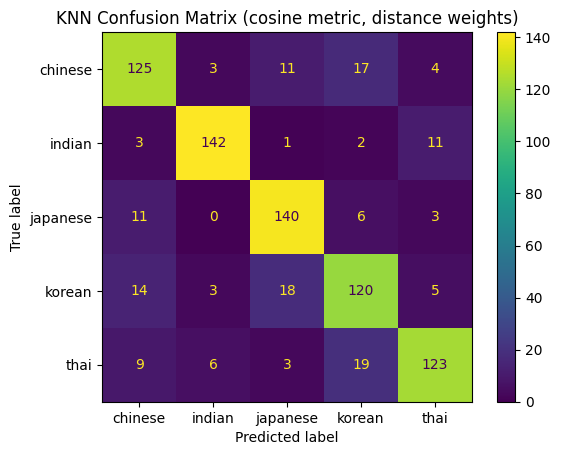

In [8]:

# KNN using cosine distance
knn_cosine = KNeighborsClassifier(n_neighbors=5, weights='distance', metric='cosine', algorithm='brute')
knn_cosine.fit(X_train, y_train)
y_cos = knn_cosine.predict(X_test)

print('Cosine KNN accuracy:', accuracy_score(y_test, y_cos))
print('\nClassification report (cosine):\n', classification_report(y_test, y_cos, target_names=class_names))
cmc = confusion_matrix(y_test, y_cos)
disp_c = ConfusionMatrixDisplay(confusion_matrix=cmc, display_labels=class_names)
disp_c.plot()
plt.title('KNN Confusion Matrix (cosine metric, distance weights)')
plt.show()



## Grid Search for best hyperparameters (cross-validated)

We'll run a `GridSearchCV` over `n_neighbors`, `weights`, and `p` (for Minkowski). We will also separately evaluate `metric='cosine'` with distance weights since mixing metrics can be tricky in a single grid.


In [9]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3,5,7,9,11],
    'weights': ['uniform','distance'],
    'p': [1,2]
}
knn = KNeighborsClassifier(metric='minkowski')

grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
print('Best params (minkowski):', grid.best_params_)
print('Best CV score:', grid.best_score_)

best_mink = grid.best_estimator_
y_best_mink = best_mink.predict(X_test)
print('Test accuracy (best minkowski):', accuracy_score(y_test, y_best_mink))
print('\nClassification report (best minkowski):\n', classification_report(y_test, y_best_mink, target_names=class_names))

# Also try cosine in its own grid (k and weights)
param_grid_cos = {'n_neighbors':[3,5,7,9,11], 'weights':['uniform','distance']}
knn_cos = KNeighborsClassifier(metric='cosine', algorithm='brute')
grid_cos = GridSearchCV(knn_cos, param_grid_cos, cv=5, scoring='accuracy', n_jobs=-1)
grid_cos.fit(X_train, y_train)
print('Best params (cosine):', grid_cos.best_params_)
print('Best CV score (cosine):', grid_cos.best_score_)
best_cos = grid_cos.best_estimator_
y_best_cos = best_cos.predict(X_test)
print('Test accuracy (best cosine):', accuracy_score(y_test, y_best_cos))
print('\nClassification report (best cosine):\n', classification_report(y_test, y_best_cos, target_names=class_names))


Best params (minkowski): {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best CV score: 0.7631406494522691
Test accuracy (best minkowski): 0.7784730913642053

Classification report (best minkowski):
               precision    recall  f1-score   support

     chinese       0.66      0.78      0.71       160
      indian       0.87      0.86      0.86       159
    japanese       0.73      0.88      0.80       160
      korean       0.89      0.66      0.76       160
        thai       0.81      0.72      0.77       160

    accuracy                           0.78       799
   macro avg       0.79      0.78      0.78       799
weighted avg       0.79      0.78      0.78       799

Best params (cosine): {'n_neighbors': 5, 'weights': 'distance'}
Best CV score (cosine): 0.802884878716745
Test accuracy (best cosine): 0.8135168961201502

Classification report (best cosine):
               precision    recall  f1-score   support

     chinese       0.77      0.78      0.78       160
      i


## PCA visualization (2D)

We'll reduce the high-dimensional ingredient space to 2 principal components for visualization. This gives intuition about class separation and whether KNN can work well in this space.


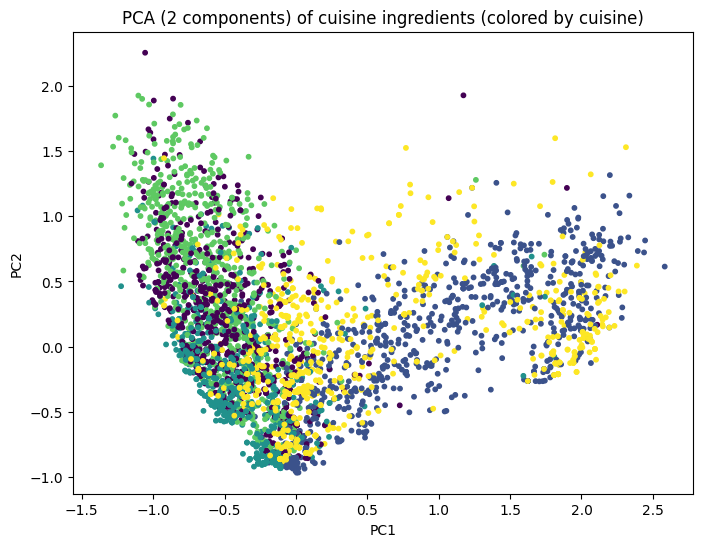

Explained variance ratio: 0.17189302101590054


In [10]:

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_enc, s=10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA (2 components) of cuisine ingredients (colored by cuisine)')
plt.show()

print('Explained variance ratio:', pca.explained_variance_ratio_.sum())
